# Part 0: Import Statements

In [1]:
# import libraries, set random seed for reproducibility
# recommended TensorFlow version >= 1.12.0
# recommended Python version >= 3.5

# basic imports
import os
import platform
import random
import shutil
import sys

# tensorflow + stats imports
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import sklearn.metrics
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

# keras imports
from keras import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

random.seed(0)

# check versions
print("TensorFlow", tf.__version__)
print("Python", platform.sys.version)

TensorFlow 1.13.1
Python 3.7.1 (v3.7.1:260ec2c36a, Oct 20 2018, 03:13:28) 
[Clang 6.0 (clang-600.0.57)]


Using TensorFlow backend.


# Part 1: Read in and clean up data

In [2]:
# read in data and get the size of the data set
X = pd.read_csv('drug_properties_final.csv', header=0, usecols=range(1,16))
print(X.head(5))
nsamples, nfts = X.shape
print(nsamples)
print(nfts)

     0    1    2      3    4           5    6    7     8    9     10  \
0  1.0  0.0  0.0  734.0  1.0  344.089603  7.0  3.0  25.0  0.0  344.3   
1  1.0  0.0  0.0  633.0  1.0  354.183109  4.0  1.0  26.0  0.0  354.4   
2  1.0  0.0  0.0  497.0  1.0  292.121178  3.0  1.0  22.0  0.0  292.3   
3  0.0  0.0  0.0  780.0  1.0  518.194068  8.0  6.0  38.0  0.0  518.6   
4  2.0  0.0  0.0  415.0  1.0  301.179027  3.0  3.0  22.0  0.0  301.4   

           11   12     13   14  
0  344.089603  2.0  121.0  2.1  
1  354.183109  8.0   71.4  4.4  
2  292.121178  1.0   52.9  2.4  
3  518.194068  5.0  156.0  6.9  
4  301.179027  2.0   68.4  2.3  
1784
15


In [3]:
# get the names of the drugs we are looking at
drugs = pd.read_csv('drug_name_list_final.csv', header=0, usecols=range(1,2))
#drugs

In [4]:
# there are more drugs that have max response and auc data since not all drugs were 
# accessible in pubchem- so load that bigger set of drugs
drugs_with_resp_auc_data = pd.read_csv('drugs.csv', usecols = range(1,2))
#drugs_with_resp_auc_data

In [5]:
# get the proper indexes from the set of all drugs to map to the pubchem drugs 
indexes = []
counter = 0
for drug in drugs_with_resp_auc_data.iloc[:,0]:
    if drug in list(drugs.iloc[:,0]):
        indexes.append(counter)
    counter = counter + 1
#indexes

In [6]:
# get values for auc
auc_values = pd.read_csv('auc.csv')
auc_values = auc_values.iloc[:,1:7]
print(auc_values.head(5))

# get values for max resp
maxresp_values = pd.read_csv('max_resp.csv')
maxresp_values = maxresp_values.iloc[:,1:7]
print(maxresp_values.head(5))

         0        1        2        3        4        5
0  428.792  460.119  277.164  443.183  408.479  408.348
1  466.491  494.689  477.969  580.252  445.541  490.083
2  413.997  261.922  438.649  360.282  417.510  322.348
3  473.658  514.225  391.226  472.357  455.033  483.530
4  499.085  454.862  284.317  498.955  490.830  436.067
         0        1       2        3       4        5
0   31.627   50.723  39.010   62.477  53.749   73.943
1  104.528  106.693  94.311  120.259  79.373  105.277
2   94.854   15.955  91.379   82.129  87.158   66.432
3   63.828   74.488  49.955  101.986  88.269   92.542
4    5.796    8.253  14.334   89.583  72.228   47.565


In [7]:
# get the re-indexed set of drugs, auc values, and max resp
final_drugs = drugs_with_resp_auc_data.iloc[indexes,0]
final_drugs

final_auc = auc_values.iloc[indexes,:]
print(final_auc)

final_maxresp = maxresp_values.iloc[indexes,:]
print(final_maxresp)

            0        1        2        3        4        5
1     466.491  494.689  477.969  580.252  445.541  490.083
2     413.997  261.922  438.649  360.282  417.510  322.348
3     473.658  514.225  391.226  472.357  455.033  483.530
4     499.085  454.862  284.317  498.955  490.830  436.067
5     439.192  464.651  441.677  496.490  482.966  438.622
6     444.042  507.567  487.697  473.677  337.470  371.668
7     453.739  466.528  386.022  412.972  410.137  422.828
8     248.701  322.929  362.261  299.505  290.917  273.682
9     468.376  456.636  207.428  425.188  439.731  444.202
10    479.920  458.372  234.410  453.171  445.012  474.465
11    508.541  501.774  476.485  556.192  478.471  528.478
12    460.677  481.198  486.335  474.319  432.789  458.532
13    558.791  529.796  526.594  572.759  547.693  529.938
15    480.426  496.298  475.607  581.248  548.532  409.708
18    285.296  321.411  320.884  356.004  298.973  286.425
19    471.813  514.940  478.022  561.303  495.328  498.6

In [8]:
# fix inf, nan values, and values exceeding the max
X[X==np.inf]=np.nan
np.where(X.values >= np.finfo(np.float32).max)
X = np.nan_to_num(X)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# check data to make sure we got rid of inf, nan, and max values
print(sum(np.isnan(X)))
print(sum(X > 10000))
print(sum(np.isinf(X)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
# and remove the nans in the auc data frame
final_auc = np.nan_to_num(final_auc)
print(sum(np.isnan(final_auc)))

[0 0 0 0 0 0]


In [11]:
# and remove the nans in the max resp data frame
final_maxresp = np.nan_to_num(final_maxresp)
print(sum(np.isnan(final_maxresp)))

[0 0 0 0 0 0]


# Part 2: Prep the MLP for training + testing

In [12]:
# Using Skicit-learn to split data into training and testing sets
# Split the data into training and testing sets
train_ft_auc, test_ft_auc, train_lab_auc, test_lab_auc = train_test_split(X, final_auc, test_size = 0.3, random_state = 0)
train_ft_resp, test_ft_resp, train_lab_resp, test_lab_resp = train_test_split(X, final_maxresp, test_size = 0.3, random_state = 0)

In [13]:
# code from here
# https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-regression-ceee5a9eadff
# https://datascienceplus.com/keras-regression-based-neural-networks/

In [14]:
# build the regressor model of 15, 10, and 6 units successively
def build_regressor():
    regressor = Sequential()
    regressor.add(Dense(units=15, input_dim=15, kernel_initializer='normal', activation='relu'))
    regressor.add(Dense(units=10, activation = 'relu'))
    regressor.add(Dense(units=6, activation = 'linear'))
    regressor.compile(optimizer='adam', loss='mse',  metrics=['mae', 'mse','accuracy'])
    return regressor

In [15]:
# set up regressor model
regressor = KerasRegressor(build_fn=build_regressor, batch_size=20,epochs=100)

In [16]:
# train the regressor model- accuracy should increase and MSE should decrease
results=regressor.fit(train_ft_auc,train_lab_auc)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1248/1248 [==============================] - 0s 155us/step - loss: 136454.9875 - mean_absolute_error: 348.9334 - mean_squared_error: 136454.9875 - acc: 0.0449
Epoch 2/100
1248/1248 [==============================] - 0s 32us/step - loss: 51351.5032 - mean_absolute_error: 187.8539 - mean_squared_error: 51351.5032 - acc: 0.0385
Epoch 3/100
1248/1248 [==============================] - 0s 32us/step - loss: 41030.4974 - mean_absolute_error: 159.5162 - mean_squared_error: 41030.4974 - acc: 0.2284
Epoch 4/100
1248/1248 [==============================] - 0s 33us/step - loss: 39853.1209 - mean_absolute_error: 157.8816 - mean_squared_error: 39853.1209 - acc: 0.4760
Epoch 5/100
1248/1248 [==============================] - 0s 33us/step - loss: 39388.7519 - mean_absolute_error: 156.4159 - mean_squared_error: 39388.7519 - acc: 0.4696
Epoch 6/100
1248/1248 [==============

1248/1248 [==============================] - 0s 33us/step - loss: 27774.1500 - mean_absolute_error: 133.0695 - mean_squared_error: 27774.1500 - acc: 0.4663
Epoch 46/100
1248/1248 [==============================] - 0s 31us/step - loss: 27675.2844 - mean_absolute_error: 132.8578 - mean_squared_error: 27675.2844 - acc: 0.4663
Epoch 47/100
1248/1248 [==============================] - 0s 31us/step - loss: 27700.1168 - mean_absolute_error: 133.3851 - mean_squared_error: 27700.1168 - acc: 0.4647
Epoch 48/100
1248/1248 [==============================] - 0s 31us/step - loss: 27570.6080 - mean_absolute_error: 133.0675 - mean_squared_error: 27570.6080 - acc: 0.4647
Epoch 49/100
1248/1248 [==============================] - 0s 32us/step - loss: 27450.2184 - mean_absolute_error: 132.5525 - mean_squared_error: 27450.2184 - acc: 0.4631
Epoch 50/100
1248/1248 [==============================] - 0s 31us/step - loss: 27332.7289 - mean_absolute_error: 131.4010 - mean_squared_error: 27332.7289 - acc: 0.4591

1248/1248 [==============================] - 0s 32us/step - loss: 20470.5969 - mean_absolute_error: 115.5139 - mean_squared_error: 20470.5969 - acc: 0.4912
Epoch 94/100
1248/1248 [==============================] - 0s 32us/step - loss: 20337.5720 - mean_absolute_error: 114.5735 - mean_squared_error: 20337.5720 - acc: 0.4928
Epoch 95/100
1248/1248 [==============================] - 0s 31us/step - loss: 20123.6893 - mean_absolute_error: 114.2808 - mean_squared_error: 20123.6893 - acc: 0.4936
Epoch 96/100
1248/1248 [==============================] - 0s 34us/step - loss: 19924.6070 - mean_absolute_error: 113.3018 - mean_squared_error: 19924.6070 - acc: 0.4944
Epoch 97/100
1248/1248 [==============================] - 0s 32us/step - loss: 20011.4141 - mean_absolute_error: 113.2123 - mean_squared_error: 20011.4141 - acc: 0.4960
Epoch 98/100
1248/1248 [==============================] - 0s 31us/step - loss: 19489.4722 - mean_absolute_error: 112.6016 - mean_squared_error: 19489.4722 - acc: 0.4952

# Part 3: Evaluate the prediction of the model

In [17]:
# get predicted value
y_pred= regressor.predict(test_ft_auc)

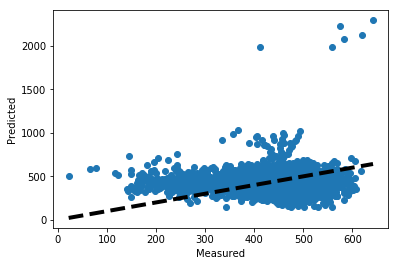

In [18]:
# plot measured vs predicted values
fig, ax = plt.subplots()
ax.scatter(test_lab_auc, y_pred)
ax.plot([test_lab_auc.min(), test_lab_auc.max()], [test_lab_auc.min(), test_lab_auc.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

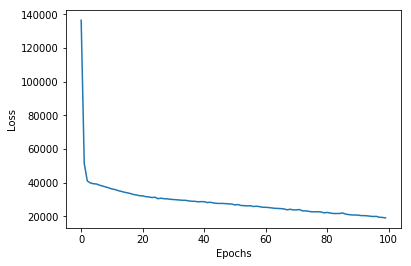

In [19]:
# plot loss over time
loss = results.history['loss']
plt.figure()
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

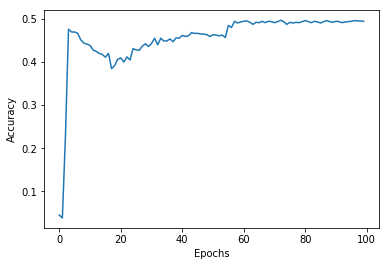

In [20]:
# plot accuracy over time
acc = results.history['acc']
plt.figure()
plt.plot(acc)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()